In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
stop_words = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

In [6]:
len(stop_words)

179

In [128]:
def prepare_text(text, remove_stopwords = True, lemmatize = True, min_word_count = 2):
    exclude_words = ['\'re', 'n\'t', '\'ve', 'em', '\'ll']
    tokenized_text = nltk.word_tokenize(text)
    filtered_tokenized_text = [token.lower() for token in tokenized_text
                                if (token.lower() not in stop_words or not remove_stopwords) and
                                token.lower() not in exclude_words and
                                re.match('\w*[a-zA-Z]\w*', token) and
                                len(token) > min_word_count]
    
    if lemmatize:
        pos_tags = nltk.pos_tag(filtered_tokenized_text)
        lemmas = []
        for token, tag in pos_tags:
            wntag = tag[0].lower()
            wntag = wntag if wntag in ['j', 'r', 'n', 'v'] else None
            if not wntag:
                lemmas.append(token)
            else:
                if wntag == 'j':
                    wntag = 'a'
                lemma = lemmatizer.lemmatize(token, wntag)
                if len(lemma) > min_word_count:
                    lemmas.append(lemma)

        prepared_text = ' '.join(lemmas)
        return prepared_text
    else:
        return ' '.join(filtered_tokenized_text)

In [129]:
def prepare_newsgroup_corpus(corpus):
    subjects = []
    cleaned_subjects_truncated = []
    cleaned_subjects = []
    categories=[]
    categories_index=[]
    cleaned_texts_truncated = []
    cleaned_texts = []
    original_texts = []
    for index, text in enumerate(newsgroups_train.data):
        subjectIndex = text.find('Subject:')
        endLineAfterSubjectIndex = text.find('\n', subjectIndex)
        linesIndex = text.find('Lines:')
        headerIndex = text.find('\n', linesIndex)
        if (headerIndex > 0 and linesIndex > 0 and endLineAfterSubjectIndex > 0 and subjectIndex > 0):
            text_without_header = text[headerIndex:]
            text_subject = text[subjectIndex:endLineAfterSubjectIndex + 1]
                    
            text_without_header = re.sub('(In article <.*>.*\n)|(.*writes:\n)|(.*wrote:\n)', ' ', text_without_header)
            text_without_header = re.sub('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', text_without_header)
            text_without_header = re.sub('(?:[a-z0-9!#$%&\'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+\/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])', '', text_without_header)
            text_without_header = re.sub('\n', ' ', text_without_header)       
            
            extracted_subject = text_subject[8:len(text_subject) - 1].strip()
            subjects.append(extracted_subject)
            prepared_subject = prepare_text(extracted_subject, remove_stopwords=False, lemmatize=False, min_word_count=1)
            prepared_subject_truncated = prepare_text(extracted_subject)
            cleaned_subjects.append(prepared_subject)
            cleaned_subjects_truncated.append(prepared_subject_truncated)
            
            prepared_text = prepare_text(extracted_subject + ' ' + text_without_header, remove_stopwords=False, lemmatize=False, min_word_count=1)
            prepared_text_truncated = prepare_text(extracted_subject + ' ' + text_without_header)
            cleaned_texts.append(prepared_text)
            cleaned_texts_truncated.append(prepared_text_truncated)
            original_texts.append(text)
            
            category_index = newsgroups_train.target[index]
            categories_index.append(category_index)
            categories.append(newsgroups_train.target_names[category_index])

    df = pd.DataFrame()
    df['Subject'] = subjects
    df['Cleaned subject truncated'] = cleaned_subjects_truncated
    df['Cleaned subject'] = cleaned_subjects
    df['Category index'] = categories_index
    df['Category'] = categories
    df['Body'] = original_texts
    df['Cleaned body truncated'] = cleaned_texts_truncated
    df['Cleaned body'] = cleaned_texts
    return df

In [131]:
newsgroup_df = prepare_newsgroup_corpus(newsgroups_train.data)
newsgroup_df

Subject       Cleaned subject truncated  \
0                        WHAT car is this!?                             car   
1                SI Clock Poll - Final Call           clock poll final call   
2                           PB questions...                        question   
3                        Re: Weitek P9000 ?                    weitek p9000   
4               Re: Shuttle Launch Question         shuttle launch question   
...                                     ...                             ...   
10928               Re: Migraines and scans                   migraine scan   
10929            Screen Death: Mac Plus/512       screen death mac plus/512   
10930  Mounting CPU Cooler in vertical case  mount cpu cooler vertical case   
10931             Re: Sphere from 4 points?                    sphere point   
10932                       stolen CBR900RR                  steal cbr900rr   

                            Cleaned subject  Category index  \
0                          what car is this               7   
1                  si clock poll final call               4   
2                              pb questions               4   
3                           re weitek p9000               1   
4                re shuttle launch question              14   
...                                     ...             ...   
10928                re migraines and scans              13   
10929             screen death mac plus/512               4   
10930  mounting cpu cooler in vertical case               3   
10931                 re sphere from points               1   
10932                       stolen cbr900rr               8   

                       Category  \
0                     rec.autos   
1         comp.sys.mac.hardware   
2         comp.sys.mac.hardware   
3                 comp.graphics   
4                     sci.space   
...                         ...   
10928                   sci.med   
10929     comp.sys.mac.hardware   
10930  comp.sys.ibm.pc.hardware   
10931             comp.graphics   
10932           rec.motorcycles   

                                                    Body  \
0      From: lerxst@wam.umd.edu (where's my thing)\nS...   
1      From: guykuo@carson.u.washington.edu (Guy Kuo)...   
2      From: twillis@ec.ecn.purdue.edu (Thomas E Will...   
3      From: jgreen@amber (Joe Green)\nSubject: Re: W...   
4      From: jcm@head-cfa.harvard.edu (Jonathan McDow...   
...                                                  ...   
10928  From: jim.zisfein@factory.com (Jim Zisfein) \n...   
10929  From: ebodin@pearl.tufts.edu\nSubject: Screen ...   
10930  From: westes@netcom.com (Will Estes)\nSubject:...   
10931  From: steve@hcrlgw (Steven Collins)\nSubject: ...   
10932  From: gunning@cco.caltech.edu (Kevin J. Gunnin...   

                                  Cleaned body truncated  \
0      car wonder anyone could enlighten car saw day ...   
1      clock poll final call nntp-posting-host carson...   
2      question well folk mac plus finally give ghost...   
3      weitek p9000 distribution world nntp-posting-h...   
4      shuttle launch question article c5owcb. tom ba...   
...                                                  ...   
10928  migraine scan david nye neurology consultation...   
10929  screen death mac plus/512 organization tuft un...   
10930  mount cpu cooler vertical case instal dx2-66 c...   
10931  sphere point nntp-posting-host hcrlgw boy emba...   
10932  steal cbr900rr distribution usa nntp-posting-h...   

                                            Cleaned body  
0      what car is this was wondering if anyone out t...  
1      si clock poll final call nntp-posting-host car...  
2      pb questions well folks my mac plus finally ga...  
3      re weitek p9000 distribution world nntp-postin...  
4      re shuttle launch question from article c5owcb...  
...                                                  ...  
10928  re migraines and scans dn from david nye dn ne.

In [132]:
newsgroup_df.iloc[0]['Cleaned body']

'what car is this was wondering if anyone out there could enlighten me on this car saw the other day it was sports car looked to be from the late 60s/ early 70s it was called bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all know if anyone can tellme model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e-mail thanks il brought to you by your neighborhood lerxst'

In [133]:
newsgroup_df.iloc[0]['Body']

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [134]:
newsgroup_df.iloc[0]['Cleaned body truncated']

'car wonder anyone could enlighten car saw day sport car look late 60s/ early 70s call bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car make history whatever info funky look car please e-mail thanks bring neighborhood lerxst'

In [135]:
import os

class BBCDirectory:
    def __init__(self, parent_path, business_path, entertainment_path, politics_path, sport_path, tech_path):
        self.parent_path = parent_path
        self.business_path = business_path
        self.entertainment_path = entertainment_path
        self.politics_path = politics_path
        self.sport_path = sport_path
        self.tech_path = tech_path
        
def get_bbc_original_directory():
    parent_dir = 'D:\Materialy_Studia\PrzetwarzanieJezykaNaturalnego\Projekt'

    bbc_root_path = os.path.join(parent_dir, 'bbc')
    bbc_business_path = os.path.join(bbc_root_path, 'business')
    bbc_entertainment_path = os.path.join(bbc_root_path, 'entertainment')
    bbc_politics_path = os.path.join(bbc_root_path, 'politics')
    bbc_sport_path = os.path.join(bbc_root_path, 'sport')
    bbc_tech_path = os.path.join(bbc_root_path, 'tech')

    directory = BBCDirectory(bbc_root_path, bbc_business_path, bbc_entertainment_path,
                             bbc_politics_path, bbc_sport_path, bbc_tech_path)

    return directory

def load_documents_from_directory(directory_path):
    documents = []
    if os.path.exists(directory_path):
        for filename in os.listdir(directory_path):
            path = os.path.join(directory_path, filename)
            file = open(path, 'r')
            content = file.read()
            documents.append(content)
            file.close()
    return documents

def load_bbc_documents():
    original_directory = get_bbc_original_directory()

    business_documents = load_documents_from_directory(original_directory.business_path)
    entertainment_documents = load_documents_from_directory(original_directory.entertainment_path)
    politics_documents = load_documents_from_directory(original_directory.politics_path)
    sport_documents = load_documents_from_directory(original_directory.sport_path)
    tech_documents = load_documents_from_directory(original_directory.tech_path)

    return {
        'business': business_documents,
        'entertainment': entertainment_documents,
        'politics': politics_documents,
        'sport': sport_documents,
        'tech': tech_documents
    }

def get_bbc_document_category_index(category):
    if category == 'business':
        return 20
    elif category == 'entertainment':
        return 21
    elif category == 'politics':
        return 22
    elif category == 'sport':
        return 23
    else:
        return 24    

def prepare_bbc_documents(bbc_data):
    subjects = []
    cleaned_subjects_truncated = []
    cleaned_subjects = []
    categories=[]
    categories_index=[]
    cleaned_texts_truncated = []
    cleaned_texts = []
    original_texts = []
    for bbc_category in bbc_data:
        bbc_articles = bbc_data[bbc_category]
        for article in bbc_articles:
            extracted_subject = article.split('\n')[0]
            prepared_subject = prepare_text(extracted_subject, remove_stopwords=False, lemmatize=False, min_word_count=1)
            prepared_subject_truncated = prepare_text(extracted_subject)
            prepared_text = prepare_text(extracted_subject + ' ' + article, remove_stopwords=False, lemmatize=False, min_word_count=1)
            prepared_text_truncated = prepare_text(extracted_subject + ' ' + article)
            category_index = get_bbc_document_category_index(bbc_category)
            
            subjects.append(extracted_subject)
            cleaned_subject = prepare_text(prepared_subject)
            cleaned_subjects_truncated = prepare_text(prepared_subject_truncated)
            cleaned_subjects.append(cleaned_subject)
            cleaned_texts.append(prepared_text)
            cleaned_texts_truncated.append(prepared_text_truncated)
            original_texts.append(article)
            categories.append(bbc_category)
            categories_index.append(category_index)
    
    df = pd.DataFrame()
    df['Subject'] = subjects
    df['Cleaned subject truncated'] = cleaned_subjects_truncated
    df['Cleaned subject'] = cleaned_subjects
    df['Category index'] = categories_index
    df['Category'] = categories
    df['Body'] = original_texts
    df['Cleaned body truncated'] = cleaned_texts_truncated
    df['Cleaned body'] = cleaned_texts
    
    return df        

In [136]:
bbc_data = load_bbc_documents()

In [137]:
bbc_df = prepare_bbc_documents(bbc_data)

In [138]:
bbc_df

Subject Cleaned subject truncated  \
0     Ad sales boost Time Warner profit        lose online gaming   
1      Dollar gains on Greenspan speech        lose online gaming   
2     Yukos unit buyer faces loan claim        lose online gaming   
3     High fuel prices hit BA's profits        lose online gaming   
4     Pernod takeover talk lifts Domecq        lose online gaming   
...                                 ...                       ...   
2220   BT program to beat dialler scams        lose online gaming   
2221    Spam e-mails tempt net shoppers        lose online gaming   
2222            Be careful how you code        lose online gaming   
2223    US cyber security chief resigns        lose online gaming   
2224   Losing yourself in online gaming        lose online gaming   

                       Cleaned subject  Category index  Category  \
0        sale boost time warner profit              20  business   
1         dollar gain greenspan speech              20  business   
2     yukos unit buyer face loan claim              20  business   
3           high fuel price hit profit              20  business   
4     pernod takeover talk lift domecq              20  business   
...                                ...             ...       ...   
2220         program beat dialler scam              24      tech   
2221    spam e-mails tempt net shopper              24      tech   
2222                      careful code              24      tech   
2223      cyber security chief resigns              24      tech   
2224                lose online gaming              24      tech   

                                                   Body  \
0     Ad sales boost Time Warner profit\n\nQuarterly...   
1     Dollar gains on Greenspan speech\n\nThe dollar...   
2     Yukos unit buyer faces loan claim\n\nThe owner...   
3     High fuel prices hit BA's profits\n\nBritish A...   
4     Pernod takeover talk lifts Domecq\n\nShares in...   
...                                                 ...   
2220  BT program to beat dialler scams\n\nBT is intr...   
2221  Spam e-mails tempt net shoppers\n\nComputer us...   
2222  Be careful how you code\n\nA new European dire...   
2223  US cyber security chief resigns\n\nThe man mak...   
2224  Losing yourself in online gaming\n\nOnline rol...   

                                 Cleaned body truncated  \
0     sale boost time warner profit sale boost time ...   
1     dollar gain greenspan speech dollar gain green...   
2     yukos unit buyer face loan claim yukos unit bu...   
3     high fuel price hit profit high fuel price hit...   
4     pernod takeover talk lift domecq pernod takeov...   
...                                                 ...   
2220  program beat dialler scams program beat dialle...   
2221  spam e-mails tempt net shopper spam e-mails te...   
2222  careful code careful code new european directi...   
2223  cyber security chief resigns cyber security ch...   
2224  lose online game lose online game online role ...   

                                           Cleaned body  
0     ad sales boost time warner profit ad sales boo...  
1     dollar gains on greenspan speech dollar gains ...  
2     yukos unit buyer faces loan claim yukos unit b...  
3     high fuel prices hit ba profits high fuel pric...  
4     pernod takeover talk lifts domecq pernod takeo...  
...                                                 ...  
2220  bt program to beat dialler scams bt program to...  
2221  spam e-mails tempt net shoppers spam e-mails t...  
2222  be careful how you code be careful how you cod...  
2223  us cyber security chief resigns us cyber secur...  
2224  losing yourself in online gaming losing yourse...  

[2225 rows x 8 columns]

In [571]:
articles_df = bbc_df

In [12]:
articles_df = bbc_df.append(newsgroup_df, ignore_index=True)

In [19]:
articles_df['Subject'].map(lambda x: len(x)).max()

120

In [114]:
all_the_news_df = pd.read_csv('D:\\Materialy_Studia\\PrzetwarzanieJezykaNaturalnego\\Projekt\\allthenews\\articles1.csv')

In [120]:
def prepare_all_the_news_documents():
    subjects = []
    cleaned_subjects = []
    cleaned_texts = []
    original_texts = []
    for index, article in all_the_news_df.iterrows():
        prepared_article = prepare_text(article.title + ' ' + article.content)        
        subjects.append(article.title)
        cleaned_subject = prepare_text(article.title)
        cleaned_subjects.append(cleaned_subject)
        cleaned_texts.append(prepared_article)
        original_texts.append(article.content)
    
    df = pd.DataFrame()
    df['Subject'] = subjects
    df['Cleaned subject'] = cleaned_subjects
    df['Body'] = original_texts
    df['Cleaned body'] = cleaned_texts
    
    return df   

In [121]:
all_the_news_df = prepare_all_the_news_documents()

In [123]:
import pickle
pickle.dump(all_the_news_df, open("all_the_news_df", "wb" ))

In [5]:
import pickle
all_the_news_df = pickle.load(open("all_the_news_df", "rb"))

In [6]:
articles_df = all_the_news_df

In [227]:
articles_df

Subject                   Cleaned subject  \
0         Ad sales boost Time Warner profit     sale boost time warner profit   
1          Dollar gains on Greenspan speech      dollar gain greenspan speech   
2         Yukos unit buyer faces loan claim  yukos unit buyer face loan claim   
3         High fuel prices hit BA's profits        high fuel price hit profit   
4         Pernod takeover talk lifts Domecq  pernod takeover talk lift domecq   
...                                     ...                               ...   
13153               Re: Migraines and scans                     migraine scan   
13154            Screen Death: Mac Plus/512         screen death mac plus/512   
13155  Mounting CPU Cooler in vertical case    mount cpu cooler vertical case   
13156             Re: Sphere from 4 points?                      sphere point   
13157                       stolen CBR900RR                    steal cbr900rr   

       Category index                  Category  \
0                  20                  business   
1                  20                  business   
2                  20                  business   
3                  20                  business   
4                  20                  business   
...               ...                       ...   
13153              13                   sci.med   
13154               4     comp.sys.mac.hardware   
13155               3  comp.sys.ibm.pc.hardware   
13156               1             comp.graphics   
13157               8           rec.motorcycles   

                                                    Body  \
0      Ad sales boost Time Warner profit\n\nQuarterly...   
1      Dollar gains on Greenspan speech\n\nThe dollar...   
2      Yukos unit buyer faces loan claim\n\nThe owner...   
3      High fuel prices hit BA's profits\n\nBritish A...   
4      Pernod takeover talk lifts Domecq\n\nShares in...   
...                                                  ...   
13153  From: jim.zisfein@factory.com (Jim Zisfein) \n...   
13154  From: ebodin@pearl.tufts.edu\nSubject: Screen ...   
13155  From: westes@netcom.com (Will Estes)\nSubject:...   
13156  From: steve@hcrlgw (Steven Collins)\nSubject: ...   
13157  From: gunning@cco.caltech.edu (Kevin J. Gunnin...   

                                            Cleaned body  
0      sale boost time warner profit sale boost time ...  
1      dollar gain greenspan speech dollar gain green...  
2      yukos unit buyer face loan claim yukos unit bu...  
3      high fuel price hit profit high fuel price hit...  
4      pernod takeover talk lift domecq pernod takeov...  
...                                                  ...  
13153  migraine scan david nye neurology consultation...  
13154  screen death mac plus/512 organization tuft un...  
13155  mount cpu cooler vertical case instal dx2-66 c...  
13156  sphere point nntp-posting-host hcrlgw boy emba...  
13157  steal cbr900rr distribution usa nntp-posting-h...  

[13158 rows x 6 columns]

In [7]:
import os
from google_trans_new import google_translator
from lxml import objectify

class AntDirectory:
    def __init__(self, parent_path, culture_path, economy_path, international_path, middle_east_path, sport_path,
                tech_path):
        self.parent_path = parent_path
        self.culture_path = culture_path
        self.economy_path = economy_path
        self.international_path = international_path
        self.middle_east_path = middle_east_path
        self.sport_path = sport_path
        self.tech_path = tech_path
        
def get_ant_directory(root_path):
    culture_path = os.path.join(root_path, 'culture')
    economy_path = os.path.join(root_path, 'economy')
    international_path = os.path.join(root_path, 'internationalNews')
    middle_east_path = os.path.join(root_path, 'middleEast')
    sport_path = os.path.join(root_path, 'sport')
    tech_path = os.path.join(root_path, 'technology')

    directory = AntDirectory(root_path, culture_path, economy_path, international_path, middle_east_path,
                             sport_path, tech_path)

    return directory

def load_documents(ant_directory):
    culture_documents = load_documents_from_directory(ant_directory.culture_path)
    economy_documents = load_documents_from_directory(ant_directory.economy_path)
    international_documents = load_documents_from_directory(ant_directory.international_path)
    middle_east_documents = load_documents_from_directory(ant_directory.middle_east_path)
    sport_documents = load_documents_from_directory(ant_directory.sport_path)
    tech_documents = load_documents_from_directory(ant_directory.tech_path)
    
    return {
        'culture': culture_documents,
        'economy': economy_documents,
        'international': international_documents,
        'middle_east': middle_east_documents,
        'sport': sport_documents,
        'tech': tech_documents,
    }

def load_ant_documents():
    alarabia = get_ant_directory('D:\\Materialy_Studia\\PrzetwarzanieJezykaNaturalnego\\Projekt\\ant\\Alarabia');
    bbc = get_ant_directory('D:\\Materialy_Studia\\PrzetwarzanieJezykaNaturalnego\\Projekt\\ant\\BBC');
    cnn = get_ant_directory('D:\\Materialy_Studia\\PrzetwarzanieJezykaNaturalnego\\Projekt\\ant\\CNN');
    france24 = get_ant_directory('D:\\Materialy_Studia\\PrzetwarzanieJezykaNaturalnego\\Projekt\\ant\\France24');
    skynews = get_ant_directory('D:\\Materialy_Studia\\PrzetwarzanieJezykaNaturalnego\\Projekt\\ant\\SkyNews');

    alarabia_articles = load_documents(alarabia)
    bbc_articles = load_documents(bbc)
    cnn_articles = load_documents(cnn)
    france24_articles = load_documents(france24)
    skynews_articles = load_documents(skynews)
    
    return {
        'alarabia': alarabia_articles,
        'bbc': bbc_articles,
        'cnn': cnn_articles,
        'france24': france24_articles,
        'skynews': skynews_articles,
    }

def get_ant_document_category_index(category):
    if category == 'culture':
        return 25
    elif category == 'economy':
        return 26
    elif category == 'international':
        return 27
    elif category == 'middle_east':
        return 28
    elif category == 'sport':
        return 29
    elif category == 'tech':
        return 30
    
def prepare_ant_documents(data):
    translator = google_translator()
    subjects = []
    categories = []
    categories_index = []
    cleaned_texts = []
    original_texts = []
    for category in data:
        print('now doing category: ' + category)
        category_index = get_ant_document_category_index(category)
        articles = data[category]
        for article in articles:
            body = ''
            subject = ''
            try:
                deserialized_article = objectify.fromstring(article)
                body = translator.translate(str(deserialized_article.TEXT))
                subject = translator.translate(str(deserialized_article.TITLE))
            except:
                continue 
            prepared_article = prepare_text(body, True, 2)
            prepared_subject = prepare_text(subject, True, 2)
            
            categories.append(category)
            categories_index.append(category_index)
            subjects.append(prepared_subject)
            cleaned_texts.append(prepared_article)
            original_texts.append(body)
    
    df = pd.DataFrame()
    df['Subject'] = subjects
    df['Category index'] = categories_index
    df['Category'] = categories
    df['Body'] = original_texts
    df['Cleaned body'] = cleaned_texts
    
    return df

In [11]:
ant_data = load_ant_documents()

In [8]:
import pickle

def prepare_ant_corpus():
    ant_alarabia_df = prepare_ant_documents(ant_data['alarabia'])
    pickle.dump(ant_alarabia_df, open("alarabia_df", "wb" ))
    ant_bbc_df = prepare_ant_documents(ant_data['bbc'])
    pickle.dump(ant_bbc_df, open("ant_bbc_df", "wb" ))
    ant_cnn_df = prepare_ant_documents(ant_data['cnn'])
    pickle.dump(ant_cnn_df, open("ant_cnn_df", "wb" ))
    ant_france24_df = prepare_ant_documents(ant_data['france24'])
    pickle.dump(ant_france24_df, open("ant_france24_df", "wb" ))
    ant_skynews_df = prepare_ant_documents(ant_data['skynews'])
    pickle.dump(ant_skynews_df, open("ant_skynews_df", "wb" ))
    return ant_alarabia_df.append(ant_bbc_df, ignore_index=True).append(ant_cnn_df, ignore_index=True).append(ant_france24_df, ignore_index=True).append(ant_skynews_df, ignore_index=True)


In [18]:
ant_df = prepare_ant_corpus()

now doing category: culture
now doing category: economy
now doing category: international
now doing category: middle_east
now doing category: sport
now doing category: tech
now doing category: culture
now doing category: economy
now doing category: international
now doing category: middle_east
now doing category: sport
now doing category: tech
now doing category: culture
now doing category: economy
now doing category: international
now doing category: middle_east
now doing category: sport
now doing category: tech
now doing category: culture
now doing category: economy
now doing category: international
now doing category: middle_east
now doing category: sport
now doing category: tech
now doing category: culture
now doing category: economy
now doing category: international
now doing category: middle_east
now doing category: sport
now doing category: tech


In [20]:
ant_df

Subject  Category index  \
0                 ahlam elsa join force asi hamaki voice              25   
1      johnny hallyday daughter reveals information d...              25   
2                    singer sheeran bestseller worldwide              25   
3             al-arabiya house hamza eggs voice kid star              25   
4      selfie death spark medium controversy fujairah...              25   
...                                                  ...             ...   
31476                      heart coffee surprising truth              30   
31477            new study demolishes oldest space dream              30   
31478                          soon different pizza chef              30   
31479  first ever observation boost life chance encel...              30   
31480                    apple samsung end war last year              30   

      Category                                               Body  \
0      culture  \nيبدو أن الصراع بين المدربين الأربعة في برنام...   
1      culture  \nفي خضمّ النزاع القائم حول تركة المغني الفرنس...   
2      culture  \nاختار الاتحاد الدولي لصناعة الفونوغرامات الم...   
3      culture  \nعاد الطفل #حمزة_لبيض، نجم برنامج THE VOICE K...   
4      culture  \nقدمت الفنانة المصرية نشوي مصطفى مسرحيتها "سي...   
...        ...                                                ...   
31476     tech  \nبين فوائد القهوة وأضرارها احتار الكثيرون، فا...   
31477     tech  \nهدمت دراسة حديثة نظرية تشبث بها علماء الفضاء...   
31478     tech  \nتعتقد شركة إكيم الفرنسية وهي شركة حديثة أن إ...   
31479     tech  \nقال باحثون الأربعاء إنه تم اكتشاف جزيئات عضو...   
31480     tech  \nأعلنت شركتا "أبل" و"سامسونغ"، الأربعاء، توصل...   

                                            Cleaned body  
0      seem conflict four coach voice witness special...  
1      midst dispute legacy french singer johnny-hall...  
2      international federation phonogram industry na...  
3      child hamza_labid star voice kid program retur...  
4      egyptian actress nashwi mustafa present play s...  
...                                                  ...  
31476  many confuse benefit harm coffee world-famous ...  
31477  recent study destroy theory astronomer cling d...  
31478  french company echem recent company believe ne...  
31479  researcher say wednesday composite organic mol...  
31480  apple samsung announce wednesday reach judicia...  

[31481 rows x 5 columns]

In [9]:
def load_ant_dataframes():
    ant_alarabia_df = pickle.load(open("alarabia_df", "rb"))
    ant_bbc_df = pickle.load(open("ant_bbc_df", "rb"))
    ant_cnn_df = pickle.load(open("ant_cnn_df", "rb"))
    ant_france24_df = pickle.load(open("ant_france24_df", "rb"))
    ant_skynews_df = pickle.load(open("ant_skynews_df", "rb"))
    return ant_alarabia_df.append(ant_bbc_df, ignore_index=True).append(ant_cnn_df, ignore_index=True).append(ant_france24_df, ignore_index=True).append(ant_skynews_df, ignore_index=True)

In [10]:
ant_df = load_ant_dataframes()
articles_df = ant_df

In [47]:
ant_bbc_df = pickle.load(open("ant_bbc_df", "rb"))
articles_df = ant_bbc_df

In [11]:
articles_df = newsgroup_df
articles_df

Subject  Category index  \
0                        WHAT car is this!?               7   
1                SI Clock Poll - Final Call               4   
2                           PB questions...               4   
3                        Re: Weitek P9000 ?               1   
4               Re: Shuttle Launch Question              14   
...                                     ...             ...   
10928               Re: Migraines and scans              13   
10929            Screen Death: Mac Plus/512               4   
10930  Mounting CPU Cooler in vertical case               3   
10931             Re: Sphere from 4 points?               1   
10932                       stolen CBR900RR               8   

                       Category  \
0                     rec.autos   
1         comp.sys.mac.hardware   
2         comp.sys.mac.hardware   
3                 comp.graphics   
4                     sci.space   
...                         ...   
10928                   sci.med   
10929     comp.sys.mac.hardware   
10930  comp.sys.ibm.pc.hardware   
10931             comp.graphics   
10932           rec.motorcycles   

                                                    Body  \
0      From: lerxst@wam.umd.edu (where's my thing)\nS...   
1      From: guykuo@carson.u.washington.edu (Guy Kuo)...   
2      From: twillis@ec.ecn.purdue.edu (Thomas E Will...   
3      From: jgreen@amber (Joe Green)\nSubject: Re: W...   
4      From: jcm@head-cfa.harvard.edu (Jonathan McDow...   
...                                                  ...   
10928  From: jim.zisfein@factory.com (Jim Zisfein) \n...   
10929  From: ebodin@pearl.tufts.edu\nSubject: Screen ...   
10930  From: westes@netcom.com (Will Estes)\nSubject:...   
10931  From: steve@hcrlgw (Steven Collins)\nSubject: ...   
10932  From: gunning@cco.caltech.edu (Kevin J. Gunnin...   

                                            Cleaned body  
0      car wonder anyone could enlighten car saw day ...  
1      clock poll final call nntp-posting-host carson...  
2      question well folk mac plus finally give ghost...  
3      weitek p9000 distribution world nntp-posting-h...  
4      shuttle launch question article c5owcb. tom ba...  
...                                                  ...  
10928  migraine scan david nye neurology consultation...  
10929  screen death mac plus/512 organization tuft un...  
10930  mount cpu cooler vertical case instal dx2-66 c...  
10931  sphere point nntp-posting-host hcrlgw boy emba...  
10932  steal cbr900rr distribution usa nntp-posting-h...  

[10933 rows x 5 columns]

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text.split()

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
tfidf_fit = vectorizer.fit(articles_df['Cleaned body'])
tfidf_fit_transform = vectorizer.fit_transform(articles_df['Cleaned body'])

D:\Programy\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [14]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=25, random_state=42)
lsa_fit = svd.fit(tfidf_fit_transform)
lsa = svd.transform(tfidf_fit_transform)

In [25]:
tfidf_fit_transform

<13158x112650 sparse matrix of type '<class 'numpy.float64'>'
	with 1291182 stored elements in Compressed Sparse Row format>

In [15]:
def calculate_category_vector(category_articles):
    articles_vectors = []
    for index, article in category_articles.iterrows():
        articles_vectors.append(lsa[index])
    return np.mean(articles_vectors, axis=0)

def get_category_centroid_vectors(articles_df):
    grouped = articles_df.groupby(['Category'])
    category_vectors_dict = {}
    for category, group in grouped:
        category_vector = calculate_category_vector(group)
        category_vectors_dict[category] = category_vector
        
    return category_vectors_dict
    

In [16]:
import numpy as np
category_vectors = get_category_centroid_vectors(articles_df)

In [36]:
import numpy as np

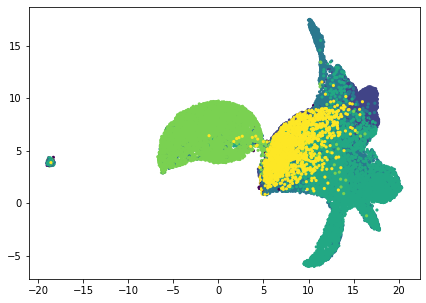

In [28]:
import umap
import matplotlib.pyplot as plt

embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(lsa)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1],
c = articles_df['Category index'],
s = 10, # size
edgecolor='none'
)
plt.show()

In [29]:
!pip install plotly==4.6.0

In [195]:
import umap
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(lsa)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=2,
    random_state=42
)

pca_result = pca.fit_transform(lsa)

In [196]:
plot_df = pd.DataFrame()
plot_df['x'] = embedding[:, 0]
plot_df['y'] = embedding[:, 1]
plot_df['Subject'] = articles_df['Subject']
plot_df['Category'] = articles_df['Category']
plot_df['Category index'] = articles_df['Category index']
plot_df = plot_df.sort_values(by=['Category index'], ascending=True)
color_indexes = []
#counter = 0
#pom_category_index = 0
#for index, document in plot_df.iterrows():
#    if document['Category index'] != pom_category_index:
#        pom_category_index = document['Category index']
#        counter = counter + 30
#    color_indexes.append(document['Category index'] + counter)
#plot_df['Color index'] = color_indexes

#for index, document in plot_df.iterrows():
#    if document['Category index'] == 6:
#        color_indexes.append('#000')
#    elif document['Category index'] == 1:
#        color_indexes.append('#F00')
#    else:
#        color_indexes.append('#FFF')
#plot_df['Color index'] = color_indexes
plot_df

x         y                            Subject     Category  \
4859  9.511325  0.177443          Re: Origins of the bible.  alt.atheism   
9653  5.740980  0.306285                Re: Theists posting  alt.atheism   
6225  8.703925  1.651283         Re: thoughts on christians  alt.atheism   
8845  6.390748  0.972760  Re: Genocide is Caused by Atheism  alt.atheism   
5583  6.024300  0.954457           Re: <Political Atheists?  alt.atheism   
...        ...       ...                                ...          ...   
1954 -1.176191 -0.730717  Seamen sail into biometric future         tech   
1953  6.898421  6.492640     Slim PlayStation triples sales         tech   
1952  1.584157  4.827138   Broadband in the UK growing fast         tech   
1962  6.974150  6.921754         Halo fans' hope for sequel         tech   
1857  1.184157  4.482820  UK gets official virus alert site         tech   

      Category index  
4859               0  
9653               0  
6225               0  
8845               0  
5583               0  
...              ...  
1954              24  
1953              24  
1952              24  
1962              24  
1857              24  

[13158 rows x 5 columns]

In [197]:
import plotly.graph_objects as go
from plotly.offline import plot

fig = go.Figure(data=go.Scattergl(x=plot_df['x'],
                                y=plot_df['y'],
                                mode='markers',
                                marker=dict(
                                    color=plot_df['Category index'],
                                ),
                                text=plot_df['Category'],
                                hoverinfo='text'
                               )
               )

fig.update_layout(title='Wizualizacja położenia wektorów dokumentów w przestrzeni semantycznej')
fig.show()

In [17]:
from gensim.models.word2vec import Word2Vec

In [18]:
# Wielkość wektora wyjściowego
embedding_size = 25

# Maksymalna odległość między bieżącym a przewidywanym słowem w zdaniu.
window_size = 5

# Minimalna liczba wystąpień słowa w korpusie, które należy uwzględnić w modelu.
# Im wyższa liczba, tym mniej słów mamy w naszym ciele
min_word = 1

# Model CBOW (0) lub skip-gram (1)
sg = 1

# Liczba iteracji (epok) uczenia sieci
iterations = 2

# Ustawienie stałej wartości zapobiega losowości wyników
# przy każdorazowym uruchomieniu
random_state = 42

# 0 negative sampling lub 1 hierarchiczny softmax
hs = 1

In [51]:
words = [article.split() for article in articles_df['Cleaned body'].tolist()]

word_2_vec_model = Word2Vec(
    sentences=words,
    size=embedding_size,
    window=window_size,
    min_count=min_word,
    sg=0,
    iter=iterations,
    seed=random_state,
    hs=hs,
)

In [50]:
word_2_vec_model.predict_output_word(['star', 'movie', 'children'], topn=30)

[('hockey', 0.000113389135),
 ('red', 8.8144734e-05),
 ('1st', 7.960444e-05),
 ('sox', 6.7031666e-05),
 ('black', 6.6476e-05),
 ('north', 6.279562e-05),
 ('star', 6.209894e-05),
 ('team', 6.125081e-05),
 ('picture', 6.0497245e-05),
 ('look', 5.9660855e-05),
 ('great', 5.8867725e-05),
 ('good', 5.6393394e-05),
 ('space', 5.6210127e-05),
 ('nhl', 5.4594722e-05),
 ('chicago', 5.3897405e-05),
 ('white', 5.3586355e-05),
 ('espn', 5.259804e-05),
 ('vs.', 5.2350777e-05),
 ('playoff', 5.2309086e-05),
 ('hulk', 5.1491625e-05),
 ('division', 5.1025356e-05),
 ('game', 5.0553026e-05),
 ('baseball', 5.007158e-05),
 ('excellent', 4.984345e-05),
 ('art', 4.9488855e-05),
 ('ice', 4.9295206e-05),
 ('station', 4.8892332e-05),
 ('box', 4.8489415e-05),
 ('toronto', 4.776346e-05),
 ('hall', 4.763567e-05)]

In [26]:
print(lol)

None


In [39]:
word_2_vec_model.most_similar('madrid', topn=100)

D:\Programy\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('barclays', 0.9202761650085449),
 ('broadmoor', 0.9184376001358032),
 ('1pm', 0.9149073362350464),
 ('stmc', 0.9134914875030518),
 ('lunchtime', 0.9110120534896851),
 ('premiership', 0.9100751876831055),
 ('ante', 0.9099615812301636),
 ('swim', 0.909290611743927),
 ('stamford', 0.909248948097229),
 ('relayed', 0.9089134931564331),
 ('dues', 0.9073261022567749),
 ('meersseman', 0.905900239944458),
 ('mid-week', 0.9058295488357544),
 ('fadeley', 0.9057521820068359),
 ('hci', 0.9050222635269165),
 ('blackpool', 0.9046263694763184),
 ('barcelona', 0.9034563302993774),
 ('shelled', 0.9029965400695801),
 ('chelsea', 0.9025278091430664),
 ('stalemate', 0.9020324945449829),
 ('ohlemeyer', 0.901849091053009),
 ('assertiveness', 0.9007677435874939),
 ('vibe', 0.9002090692520142),
 ('ago*', 0.8993238806724548),
 ('coaching', 0.8993150591850281),
 ('fired', 0.8990879058837891),
 ('fiasco', 0.8985560536384583),
 ('listened', 0.8982475996017456),
 ('polling', 0.8975428342819214),
 ('faraway', 0.89

In [28]:
def create_document_word2vec_vector(text):
    #words: list = [word for word in text.split() if word in set(word_2_vec_model.wv.index2word)]
    words = [word for word in text.split()]
    vector = np.mean(word_2_vec_model.wv[words], axis=0, dtype="float64")
    return vector

def calculate_word2vec_average_document_vectors():
    vectors = []
    for index, document in articles_df.iterrows():
        vector = create_document_word2vec_vector(document['Cleaned body'])
        vectors.append(vector)
    return vectors

In [40]:
word2vec_document_vectors = calculate_word2vec_average_document_vectors()

NameError: name 'word_2_vec_model' is not defined

In [215]:
len(word2vec_document_vectors)

13158

In [29]:
def calculate_category_vector_word2vec(category_articles):
    articles_vectors = []
    for index, article in category_articles.iterrows():
        articles_vectors.append(word2vec_document_vectors[index])
    return np.mean(articles_vectors, axis=0)

def get_category_centroid_vectors_word2vec(articles_df):
    grouped = articles_df.groupby(['Category'])
    category_vectors_dict = {}
    for category, group in grouped:
        category_vector = calculate_category_vector_word2vec(group)
        category_vectors_dict[category] = category_vector
        
    return category_vectors_dict

In [30]:
category_vectors = get_category_centroid_vectors_word2vec(articles_df)

NameError: name 'word2vec_document_vectors' is not defined

In [18]:
from scipy import sparse
from scipy.sparse import vstack

def create_tfidf_vector(text):
    vector = np.zeros(len(vectorizer.vocabulary_))
    text_array = text.split()
    for word in text_array:
        word_index = vectorizer.vocabulary_.get(word)
        if word_index is not None:
            tf = text_array.count(word)
            idf = vectorizer.idf_[word_index]
            vector[word_index] = tf * idf
    return sparse.csr_matrix(vector)

def create_articles_subject_vectors():
    subject_tfidf = []
    for index, document in articles_df.iterrows():
        subject_tfidf.append(create_tfidf_vector(document['Cleaned subject']))
    return vstack(subject_tfidf)

In [19]:
subject_tfidf = create_articles_subject_vectors()

In [128]:
subject_tfidf

<13158x112650 sparse matrix of type '<class 'numpy.float64'>'
	with 45457 stored elements in Compressed Sparse Row format>

In [105]:
create_tfidf_vector('real madrid')

<1x112650 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [114]:
subject_tfidf.nbytes

105264

In [19]:
articles_df.memory_usage()

Index                 128
Subject            105264
Cleaned subject    105264
Category index     105264
Category           105264
Body               105264
Cleaned body       105264
dtype: int64

In [100]:
articles_df['Category'].values[13153]

'sci.med'

In [96]:
category_vectors

{'alt.atheism': array([ 0.14285274, -0.05060959,  0.08661905, -0.01739055, -0.01154796,
        -0.01100831,  0.01189815,  0.00269444, -0.00058152,  0.00341415,
        -0.00817681,  0.00817675, -0.01085954, -0.004162  , -0.00983497,
         0.00399007, -0.00786541, -0.02813624,  0.01583557,  0.02447881,
         0.01095783, -0.01895492, -0.02644846,  0.00694996,  0.01933118]),
 'business': array([ 0.12193913, -0.0491052 , -0.08461717,  0.06313827, -0.04624609,
         0.00765826,  0.03416139, -0.06353594,  0.0074615 ,  0.01976517,
        -0.06690438,  0.03604594,  0.01395917,  0.00397201, -0.00629179,
        -0.06072724,  0.00332322,  0.00552651,  0.0018698 ,  0.01449913,
         0.00333   , -0.01348053,  0.00569719, -0.00558104,  0.01891513]),
 'comp.graphics': array([ 0.09808729,  0.0736808 ,  0.01116911, -0.00575243, -0.01708991,
        -0.03063493, -0.02269147, -0.00913848, -0.00672004,  0.01105798,
        -0.00205343, -0.02873006, -0.01677075, -0.00202759,  0.01427417,
   

In [110]:
a= tfidf_fit.transform(['morda psie'])
b =tfidf_fit.transform(['ssij psie'])

vstack([a, b])

<2x112650 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [112]:
list(category_vectors.keys())

['alt.atheism',
 'business',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'entertainment',
 'misc.forsale',
 'politics',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'sport',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc',
 'tech']

In [116]:
slownik = {'b': 1, 'a': 2}

In [118]:
slownik.values()

dict_values([1, 2])

In [123]:
articles_df.memory_usage()

Index                 128
Subject            105264
Cleaned subject    105264
Category index     105264
Category           105264
Body               105264
Cleaned body       105264
dtype: int64

In [79]:
ok = list(articles_df['Category'].unique())
ok.sort()
ok

['alt.atheism',
 'business',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'entertainment',
 'misc.forsale',
 'politics',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'sport',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc',
 'tech']

In [113]:
lsa.nbytes

2631600

In [23]:
articles_df_category_indexes = articles_df['Category index']
articles_df_category_indexes = articles_df_category_indexes.values
articles_df_category_indexes

array([20, 20, 20, ...,  3,  1,  8], dtype=int64)

In [65]:
lsa_fit.components_

array([[ 1.93443924e-06,  1.93443924e-06,  1.93443924e-06, ...,
         2.74940308e-05,  3.74594154e-05,  1.97087923e-04],
       [ 2.91152919e-06,  2.91152919e-06,  2.91152919e-06, ...,
        -1.08098890e-05,  5.07372051e-05, -1.65423655e-04],
       [-5.89001384e-07, -5.89001385e-07, -5.89001384e-07, ...,
         1.86104713e-05, -7.23020841e-05, -7.63958994e-05],
       ...,
       [-3.80111007e-06, -3.80111007e-06, -3.80111007e-06, ...,
         2.59359518e-05,  2.72635304e-04,  3.62477513e-04],
       [-1.18208107e-06, -1.18208107e-06, -1.18208107e-06, ...,
        -4.90701506e-06,  4.01319138e-05, -5.96312463e-04],
       [-1.16153061e-06, -1.16153061e-06, -1.16153061e-06, ...,
         2.64125712e-05, -3.86387765e-04, -5.23850113e-06]])

In [104]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def create_query_vector(prepared_query):
    query_terms_to_topics = []
    query_vector = []
    terms_to_topics = lsa_fit.components_.transpose()
    for word in prepared_query.split():
        index = tfidf_fit.vocabulary_.get(word)
        if index is not None:
            query_terms_to_topics.append(terms_to_topics[index].tolist())
    if len(query_terms_to_topics) > 0:
        query_vector = np.sum(np.array(query_terms_to_topics), axis=0).tolist()
    return np.array(query_vector)

def get_similarities(query_vector):
    similarities = []
    reshaped_query_vector = query_vector.reshape(1, -1)
    for index, doc in enumerate(lsa):     
        doc_category_vector = category_vectors[articles_df.iloc[index].Category]
        query_category_similarity = cosine_similarity(reshaped_query_vector, doc_category_vector.reshape(1, -1))[0][0]
        query_doc_similarity = cosine_similarity(reshaped_query_vector, doc.reshape(1, -1))[0][0]
        similarity = query_category_similarity * query_doc_similarity
        similarities.append(query_doc_similarity)
    return similarities

def get_semantic_similarities(prepared_query):
    query_vector = create_query_vector(prepared_query)
    similarities = []
    if len(query_vector) > 0:
        similarities = get_similarities(query_vector)
    return similarities

def get_body_similarities(prepared_query):
    similarities = []
    query_vector = create_tfidf_vector(prepared_query)
    for index, document in articles_df.iterrows():
        document_vector = tfidf_fit_transform[index]
        similarities.append(cosine_similarity(query_vector, document_vector)[0][0])
    return similarities

def get_subject_similarities(prepared_query):
    similarities = []
    query_vector = create_tfidf_vector(prepared_query)
    for index, document in articles_df.iterrows():
        subject_vector = subject_tfidf[index]
        similarities.append(cosine_similarity(query_vector, subject_vector)[0][0])
    return similarities

def get_word2vec_similarities(prepared_query):
    similarities = []
    query_vector = create_document_word2vec_vector(prepared_query)
    reshaped_query_vector = np.array(query_vector).reshape(1, -1)
    for index, document in articles_df.iterrows():
        word2vec_document_vector = word2vec_document_vectors[index]
        similarities.append(cosine_similarity(reshaped_query_vector, word2vec_document_vector.reshape(1, -1))[0][0])
    return similarities

def normalize_similarity_vector(semantic_similarity, query_category_semantic_similarity):
    if semantic_similarity < 0 or query_category_semantic_similarity < 0:
        return -1 * abs(semantic_similarity * query_category_semantic_similarity)
    else:
        return semantic_similarity * query_category_semantic_similarity

def get_documents(query):
    prepared_query = prepare_text(query)
    #semantic_similarities = get_semantic_similarities(prepared_query)
    #subject_similarities = get_subject_similarities(prepared_query)
    #body_similarities = get_body_similarities(prepared_query)
    #word2vec_similarities = get_word2vec_similarities(prepared_query)
    
    #overall_scores = []
    #for index, semantic_similarity in enumerate(semantic_similarities):
        #body_similarities[index] = body_similarities[index] * semantic_similarity
        #subject_similarities[index] = subject_similarities[index] * semantic_similarity
        #score = semantic_similarity#(subject_similarities[index] + semantic_similarity + body_similarities[index]) / 3
        #overall_scores.append(score)
        
    tfidf_query_vector = create_tfidf_vector(prepared_query)
    if tfidf_query_vector.nnz == 0:
        return []
    semantic_query_vector = create_query_vector(prepared_query)
    reshaped_semantic_query_vector = semantic_query_vector.reshape(1, -1)

    semantic_similarities = cosine_similarity(reshaped_semantic_query_vector, lsa)
    query_category_semantic_similarities = cosine_similarity(reshaped_semantic_query_vector, np.array(list(category_vectors.values())))
    subject_similarities = cosine_similarity(tfidf_query_vector, subject_tfidf)
    body_similarities = cosine_similarity(tfidf_query_vector, tfidf_fit_transform)
    normalized_semantic_similarities = []

    overall_scores = []
    for index in range(len(lsa)):
        semantic_similarity = semantic_similarities[0][index]#normalize_similarity_vector(semantic_similarities[0][index], query_category_semantic_similarities[0][articles_df_category_indexes[index]])
        #semantic_similarity = semantic_similarities[0][index] * query_category_semantic_similarities[0][articles_df_category_indexes[index]]
        normalized_semantic_similarities.append(semantic_similarity)
        
        score = (body_similarities[0][index] * semantic_similarity +
                 subject_similarities[0][index] +
                 semantic_similarity) / 3
        overall_scores.append(score)
    
    articles_df_copy = articles_df.copy()
    articles_df_copy['Subject score'] = subject_similarities[0]
    articles_df_copy['Semantic score'] = normalized_semantic_similarities
    articles_df_copy['Body score'] = body_similarities[0]
    #articles_df_copy['Word2vec doc avg score'] = word2vec_similarities

    articles_df_copy['Score'] = overall_scores
    articles_df_copy = articles_df_copy[articles_df_copy['Score'] > 0]
    articles_df_copy = articles_df_copy.sort_values(by=['Score'], ascending=False).head(30)
    
    return articles_df_copy
    


In [105]:
get_documents('kurwa')

[]

In [64]:
prepared_query = prepare_text('video card for sale')
semantic_query_vector = create_query_vector(prepared_query)
reshaped_semantic_query_vector = semantic_query_vector.reshape(1, -1)
query_category_semantic_similarities = cosine_similarity(reshaped_semantic_query_vector, category_vectors['misc.forsale'].reshape(1, -1))

In [65]:
query_category_semantic_similarities

array([[0.47266026]])

In [131]:
import datetime
start = datetime.datetime.now()
similarities = []
prepared_query = prepare_text('jesus christ')
query_vector = create_tfidf_vector(prepared_query)
reshaped_query_vector = np.array(query_vector).reshape(1, -1)
for index, document in articles_df.iterrows():
    subject_vector = subject_tfidf[index]
    similarities.append(cosine_similarity(query_vector, subject_vector)[0][0])
end = datetime.datetime.now()
delta = end - start
delta

datetime.timedelta(seconds=8, microseconds=653808)

In [31]:
import datetime
start = datetime.datetime.now()
prepared_query = prepare_text('star wars')
#tfidf_query_vector = create_tfidf_vector(prepared_query)
semantic_query_vector = create_query_vector(prepared_query)
reshaped_semantic_query_vector = semantic_query_vector.reshape(1, -1)

semantic_similarities = cosine_similarity(reshaped_semantic_query_vector, lsa)
#query_category_semantic_similarities = cosine_similarity(reshaped_semantic_query_vector, category_vectors)

#subject_similarities = cosine_similarity(tfidf_query_vector, subject_tfidf)
#body_similarities = cosine_similarity(tfidf_query_vector, tfidf_fit_transform)
#overall_scores = []
#for index in range(len(lsa)):   
#        score = (body_similarities[0][index] * semantic_similarities[0][index] +
#                 subject_similarities[0][index] * semantic_similarities[0][index] +
#                 semantic_similarities[0][index]) / 3
#        overall_scores.append(score)

semantic_similarities2 = get_semantic_similarities(prepared_query)
for index, doc in enumerate(lsa): 
    query_doc_similarity = cosine_similarity(reshaped_semantic_query_vector, doc.reshape(1, -1))[0][0]
    semantic_similarities2.append(query_doc_similarity)

#subject_similarities2 = get_subject_similarities(prepared_query)
#body_similarities2 = get_body_similarities(prepared_query)
#overall_scores2 = []
#for index in range(len(lsa)):
#    score = (body_similarities2[index] * semantic_similarities2[index] +
#            subject_similarities2[index] * semantic_similarities2[index] +
#            semantic_similarities2[index]) / 3
#    overall_scores2.append(score)

end = datetime.datetime.now()
delta = end - start
delta

datetime.timedelta(seconds=7, microseconds=590577)

In [146]:
articles_df.iloc[7972]

Subject            Re: hard times investments was: (no subject gi...
Cleaned subject                    hard time investment subject give
Category index                                                    18
Category                                          talk.politics.misc
Body               From: acheng@ncsa.uiuc.edu (Albert Cheng)\nSub...
Cleaned body       hard time investment subject give originator m...
Name: 7972, dtype: object

In [141]:
tfidf_fit.transform(['star war']).data

array([0.70069559, 0.71346037])

In [143]:
create_query_vector('star war')

array([ 0.04365109, -0.05515142, -0.03364784, -0.0128879 , -0.01155501,
       -0.01061057, -0.03070129, -0.03941441,  0.10732302, -0.04444755,
        0.13118165, -0.0554315 ,  0.04271537, -0.04619602,  0.00499725,
       -0.01903278, -0.00189767, -0.04543737,  0.0079041 , -0.01019815,
       -0.02311825, -0.012098  ,  0.01977931,  0.01510892,  0.01067388])

In [30]:
tfidf_query_vector = tfidf_fit.transform(['star war'])
tfidf_query_vector

<1x112650 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [37]:
cosine_similarity(tfidf_query_vector, subject_tfidf)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [71]:
kek = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [82]:
kek[3*(2 - 1):3*(2-1)+3]

[4, 5, 6]

In [87]:
kek[3:6]

[4, 5, 6]

In [103]:
create_tfidf_vector('star war').nnz

2

In [54]:
!python -m pip install -U symspellpy

In [103]:
import pkg_resources
from symspellpy import SymSpell, Verbosity
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")

In [83]:
dictionary_path

'D:\\Programy\\Anaconda\\lib\\site-packages\\symspellpy\\frequency_dictionary_en_82_765.txt'

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
count_vectorizer_transform = count_vectorizer.fit(bbc_df['Cleaned body'])

In [81]:
count_vectorizer_transform.vocabulary_

{'sale': 18656,
 'boost': 2983,
 'time': 21562,
 'warner': 23155,
 'profit': 16903,
 'quarterly': 17196,
 'medium': 13739,
 'giant': 9126,
 'timewarner': 21573,
 'jump': 11809,
 'âł600m': 24111,
 'three': 21489,
 'month': 14271,
 'december': 5750,
 '639m': 423,
 'year': 23791,
 'earlier': 6905,
 'firm': 8294,
 'one': 15263,
 'big': 2664,
 'investor': 11332,
 'google': 9341,
 'benefit': 2531,
 'high': 10143,
 'speed': 20107,
 'internet': 11248,
 'connection': 4863,
 'higher': 10146,
 'advert': 886,
 'say': 18808,
 'fourth': 8610,
 'quarter': 17195,
 'rise': 18277,
 'buoy': 3418,
 'off': 15169,
 'gain': 8868,
 'offset': 15189,
 'dip': 6264,
 'bros': 3291,
 'less': 12600,
 'user': 22664,
 'aol': 1498,
 'friday': 8719,
 'own': 15622,
 'search': 19022,
 'engine': 7333,
 'business': 3470,
 'mixed': 14143,
 'fortune': 8584,
 'lose': 12967,
 'subscriber': 20658,
 'lower': 13004,
 'precede': 16678,
 'however': 10437,
 'company': 4660,
 'underlying': 22273,
 'exceptional': 7687,
 'item': 11473,


In [79]:
bbc_df

Subject                   Cleaned subject  \
0     Ad sales boost Time Warner profit     sale boost time warner profit   
1      Dollar gains on Greenspan speech      dollar gain greenspan speech   
2     Yukos unit buyer faces loan claim  yukos unit buyer face loan claim   
3     High fuel prices hit BA's profits        high fuel price hit profit   
4     Pernod takeover talk lifts Domecq  pernod takeover talk lift domecq   
...                                 ...                               ...   
2220   BT program to beat dialler scams         program beat dialler scam   
2221    Spam e-mails tempt net shoppers    spam e-mails tempt net shopper   
2222            Be careful how you code                      careful code   
2223    US cyber security chief resigns      cyber security chief resigns   
2224   Losing yourself in online gaming                lose online gaming   

      Category index  Category  \
0                 20  business   
1                 20  business   
2                 20  business   
3                 20  business   
4                 20  business   
...              ...       ...   
2220              24      tech   
2221              24      tech   
2222              24      tech   
2223              24      tech   
2224              24      tech   

                                                   Body  \
0     Ad sales boost Time Warner profit\n\nQuarterly...   
1     Dollar gains on Greenspan speech\n\nThe dollar...   
2     Yukos unit buyer faces loan claim\n\nThe owner...   
3     High fuel prices hit BA's profits\n\nBritish A...   
4     Pernod takeover talk lifts Domecq\n\nShares in...   
...                                                 ...   
2220  BT program to beat dialler scams\n\nBT is intr...   
2221  Spam e-mails tempt net shoppers\n\nComputer us...   
2222  Be careful how you code\n\nA new European dire...   
2223  US cyber security chief resigns\n\nThe man mak...   
2224  Losing yourself in online gaming\n\nOnline rol...   

                                           Cleaned body  
0     sale boost time warner profit sale boost time ...  
1     dollar gain greenspan speech dollar gain green...  
2     yukos unit buyer face loan claim yukos unit bu...  
3     high fuel price hit profit high fuel price hit...  
4     pernod takeover talk lift domecq pernod takeov...  
...                                                 ...  
2220  program beat dialler scams program beat dialle...  
2221  spam e-mails tempt net shopper spam e-mails te...  
2222  careful code careful code new european directi...  
2223  cyber security chief resigns cyber security ch...  
2224  lose online game lose online game online role ...  

[2225 rows x 6 columns]

In [98]:
dictcopy = count_vectorizer_transform.vocabulary_.copy()

In [100]:
f = open(dictionary_path, "r")
Lines = f.readlines()
for line in Lines: 
    splitted = line.split()
    if splitted[0] not in dictcopy:
        dictcopy[splitted[0]] = splitted[1]
f.close()

In [101]:
len(dictcopy)

89740

In [102]:
f = open("vocab.txt", "w")
for key in dictcopy:
    try:
        string = str(key) + ' ' + str(dictcopy[key]) + '\n'
        f.write(string)
    except UnicodeEncodeError:
        continue
f.close()

In [116]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = 'C:\\Users\\Kamil\\vocab.txt'
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
input_term = ("mamnaimiekamil")
# max edit distance per lookup (per single word, not per whole input string)
suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
for suggestion in suggestions:
    print(suggestion)

mania mihkail, 5, 0
